## Experience of EEGv feature selection

In this experience, we try to find a selection of EEG features that are enough to train a random forest classifier.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(dataProcessing)
importlib.reload(splitData)

<module 'splitData' from '/mnt/remote/workspaces/magali.egger/TBproject/Travail_Bachelor/InputRelevance/../Library/splitData.py'>

In [5]:
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_simplify.pkl', 'rb') as f:
    df = pickle.load(f)
df['breed'] = df['mouse'].apply(lambda x: breedManip.getBreedIndex(breedManip.getBreedOfMouse(x)))

In [18]:
# read the df_train from pickle
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

# read the df_test from pickle
with open('/home/magali.egger/workspace/TBproject/Travail_Bachelor/Data/df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)

#### Experience matrix correlation 
Find a new feature to replace the one coming from EMG.

/tmp/ipykernel_3955727/2275939158.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


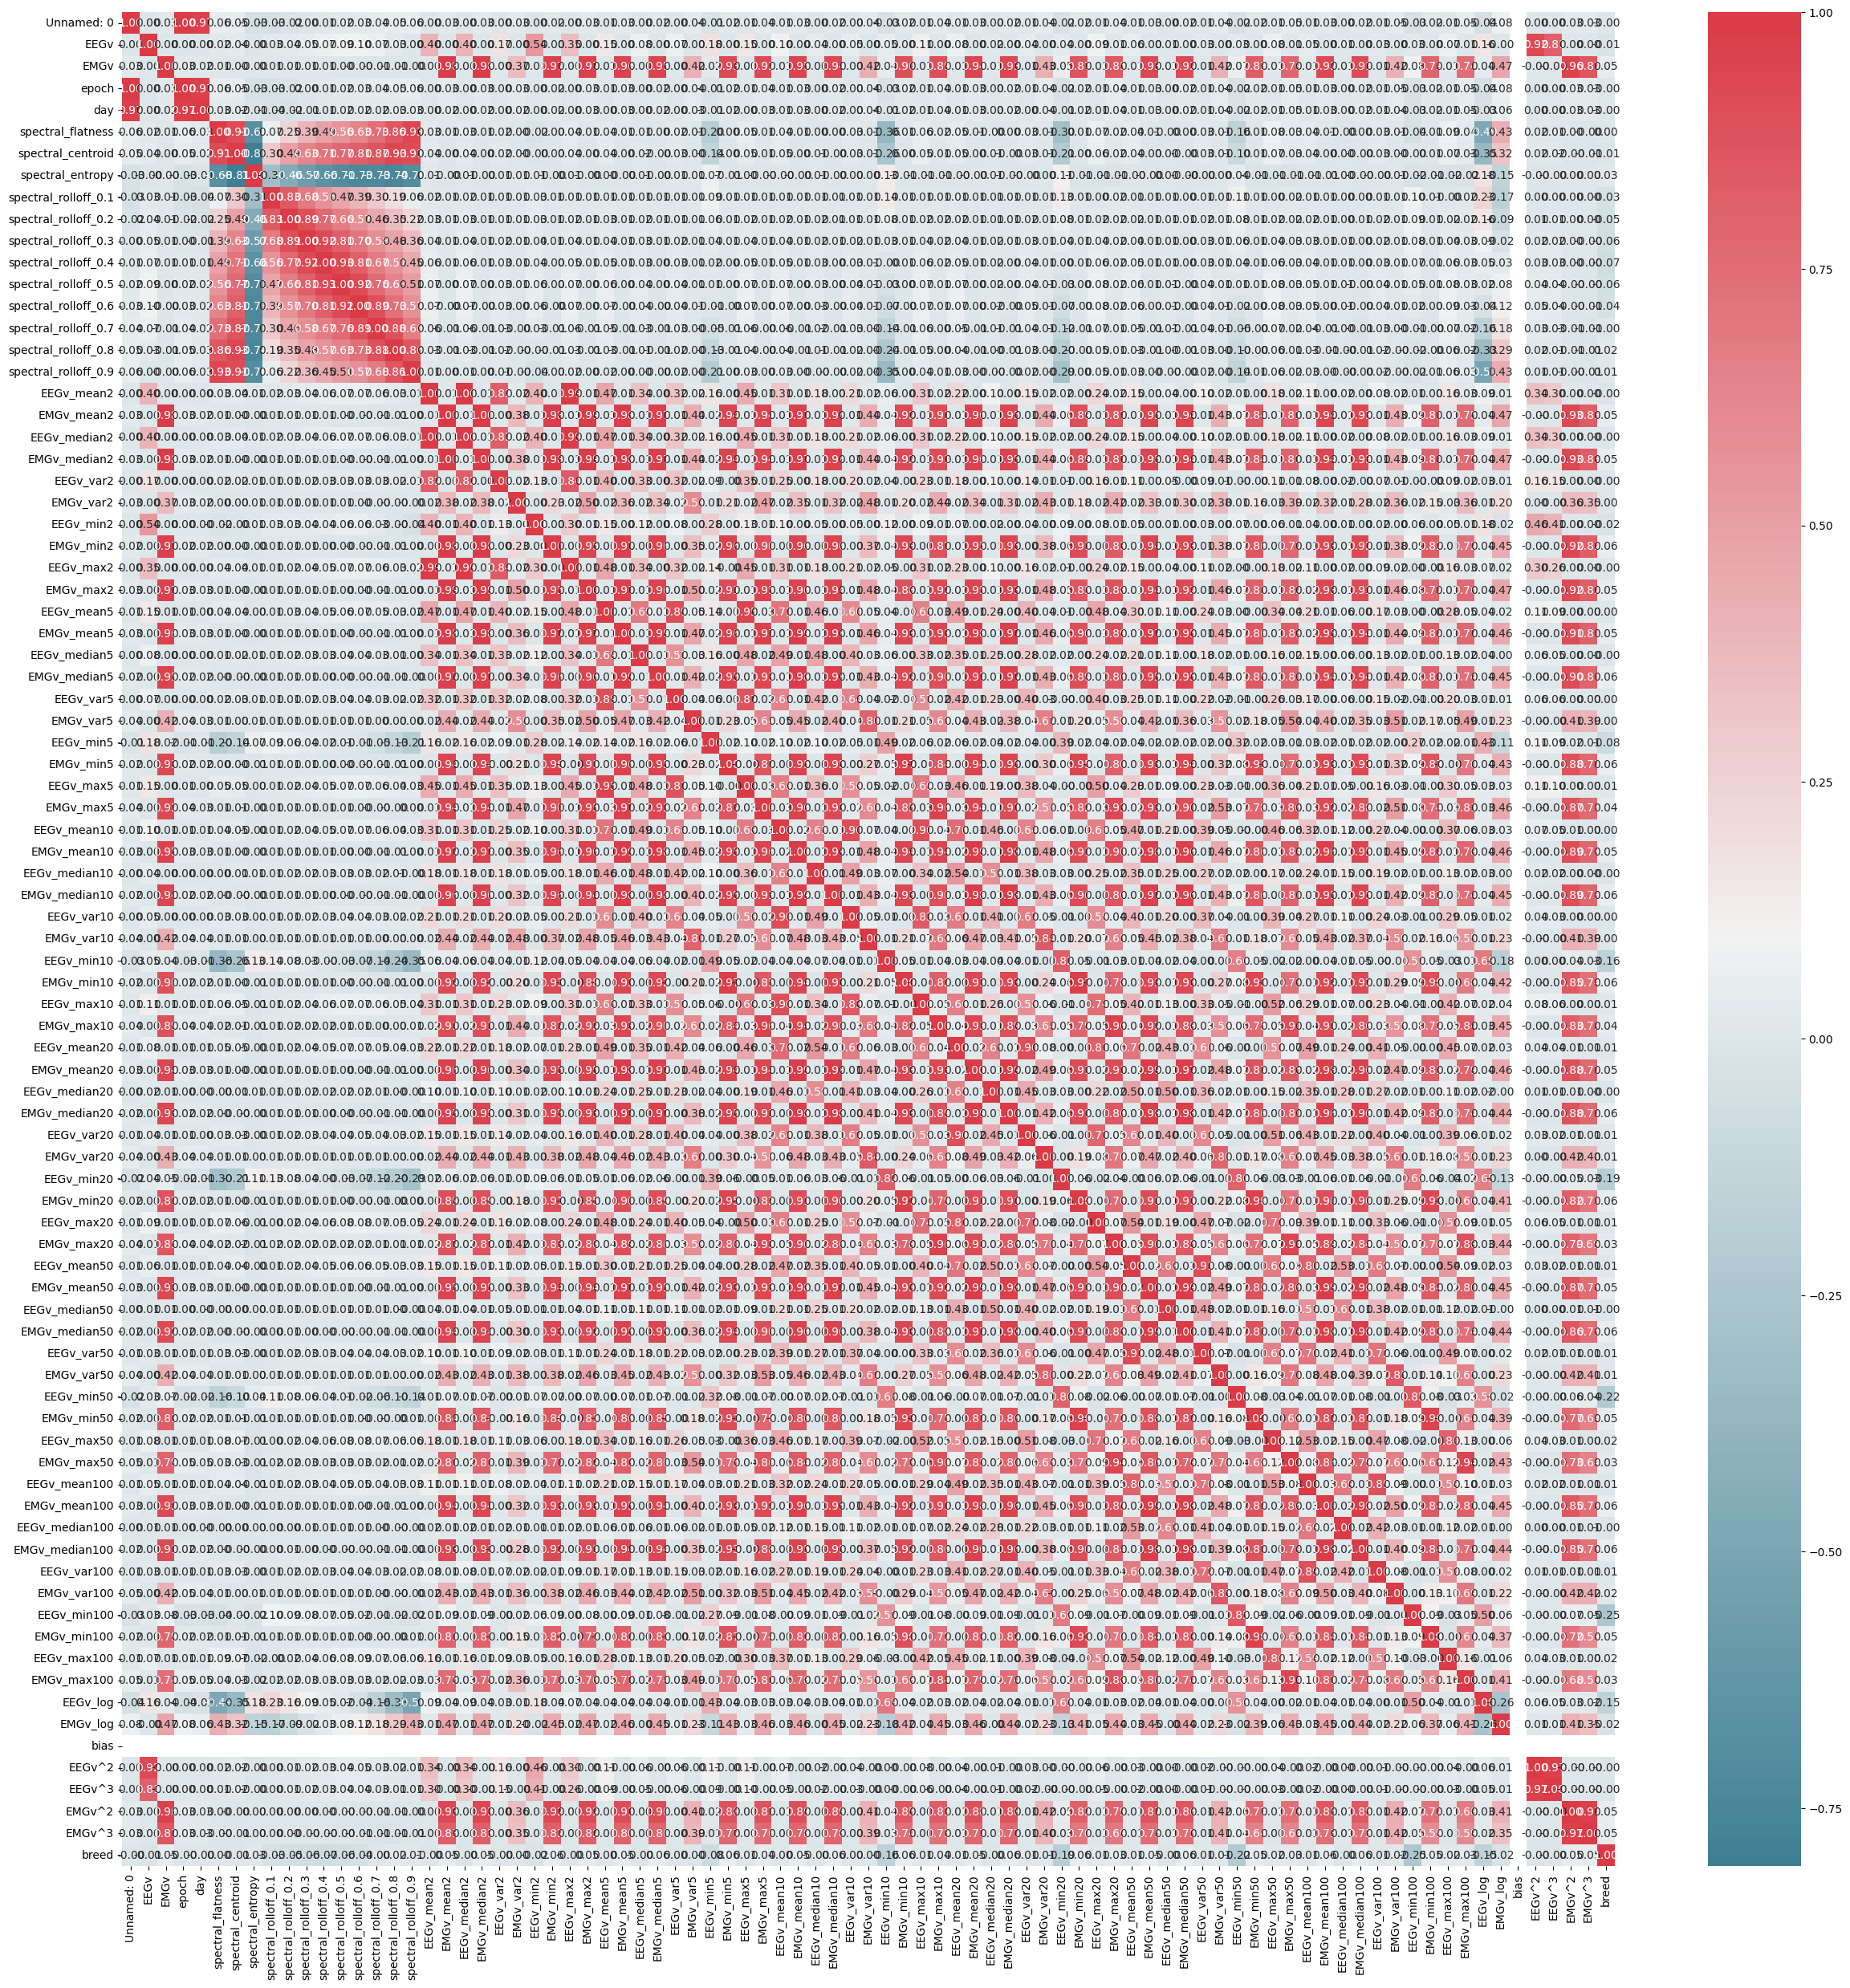

In [6]:
# display the correlation matrix
corr = df.corr()
plt.figure(figsize=(30,30))
# color from green to red
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap=cmap)
plt.show()

Small note on the correlation of features with the breed. We can see that the features that are the most correlated with the breeds are : EEGv_log, EEGv_min100, EEGv_min50, EEGv_min20, EEGv_min10, spectral_entropy.

/tmp/ipykernel_1410260/973949443.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[eeg_columns + emg_columns].corr()


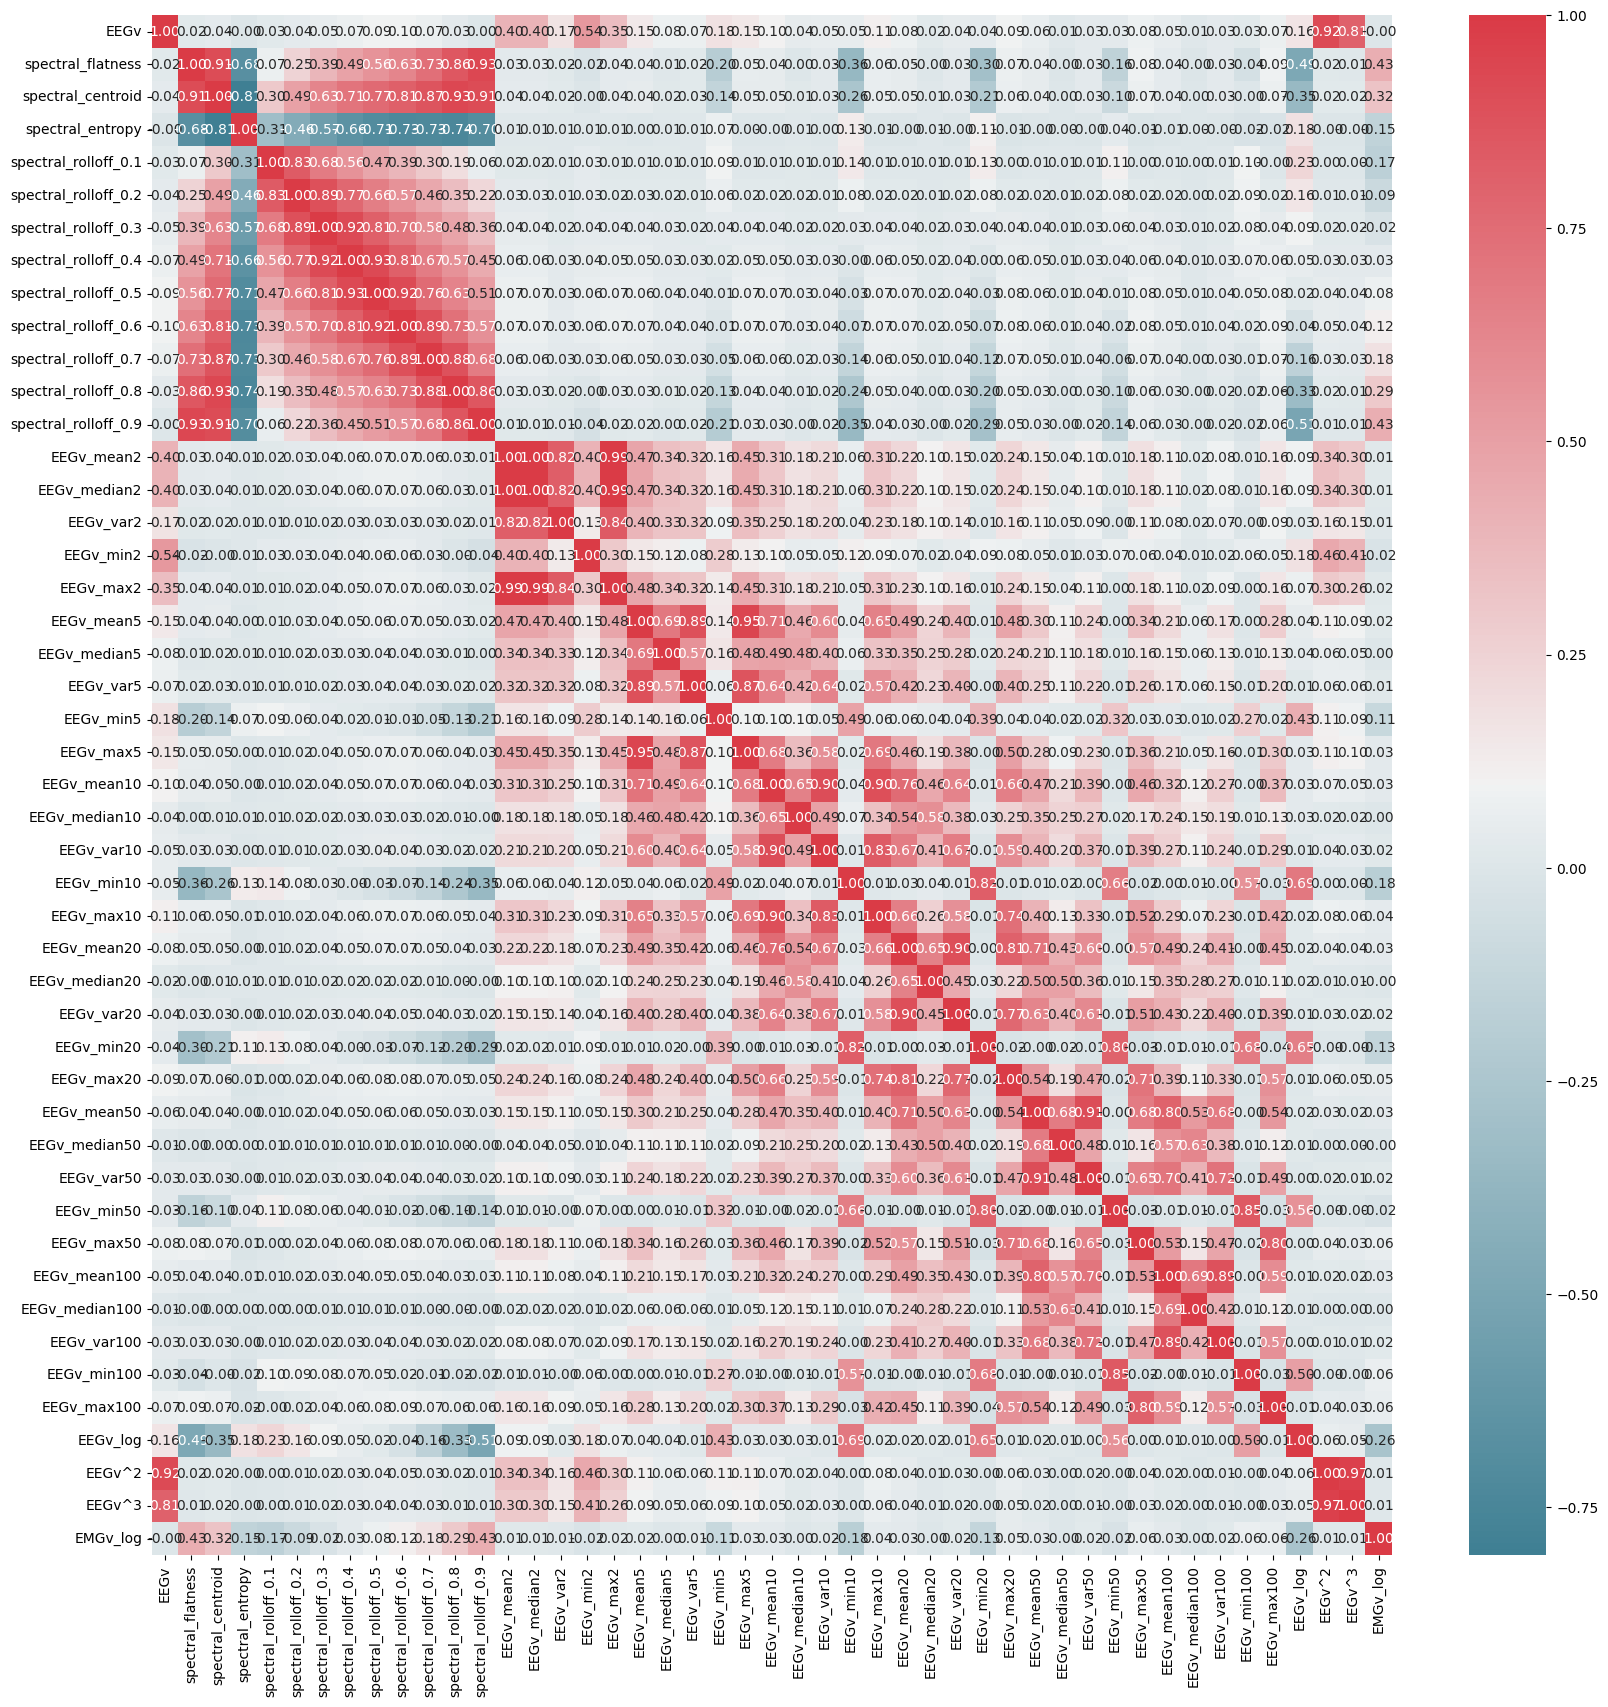

In [20]:
# display the correlation matrix for the EEG signals in relation to the EMGv log
eeg_columns = ['rawState', 'EEGv', 'spectral_flatness', 'spectral_centroid', 'spectral_entropy', 'spectral_rolloff_0.1', 'spectral_rolloff_0.2', 'spectral_rolloff_0.3', 'spectral_rolloff_0.4', 'spectral_rolloff_0.5', 'spectral_rolloff_0.6', 'spectral_rolloff_0.7', 'spectral_rolloff_0.8', 'spectral_rolloff_0.9', 'EEGv_mean2', 'EEGv_median2', 'EEGv_var2', 'EEGv_min2', 'EEGv_max2', 'EEGv_mean5', 'EEGv_median5', 'EEGv_var5', 'EEGv_min5', 'EEGv_max5', 'EEGv_mean10', 'EEGv_median10', 'EEGv_var10', 'EEGv_min10', 'EEGv_max10', 'EEGv_mean20', 'EEGv_median20', 'EEGv_var20', 'EEGv_min20', 'EEGv_max20', 'EEGv_mean50', 'EEGv_median50', 'EEGv_var50', 'EEGv_min50', 'EEGv_max50', 'EEGv_mean100', 'EEGv_median100', 'EEGv_var100', 'EEGv_min100', 'EEGv_max100', 'EEGv_log', 'EEGv^2', 'EEGv^3']
emg_columns = ['EMGv_log']
corr = df[eeg_columns + emg_columns].corr()
# color from pink to blue
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap=cmap)
plt.show()

#### Experience : selection of a new feature based on importance EEGv_mean2
The first experience is to train and test a model with only four columns: spectral flatness, spectral roll-off 0.9, EEGv_max 2 and EEGv_mean2. Compare to the validation_importance experience, the EMGv_log has been replaced by the EEGv_mean2. The goal is to see if the model can be trained with only four features coming all from EEG.

In [21]:
eeg_selected = ['rawState', 'spectral_flatness', 'spectral_rolloff_0.9', 'EEGv_max2','EEGv_mean2', 'EEGv_median2', 'state']

In [22]:
df_train = df_train[eeg_selected]
df_test = df_test[eeg_selected]
df_train = dataProcessing.rebalance_state(df_train, 13)
x_train, x_test, y_train, y_test, le = splitData.encode_scale_data(df_train, df_test, 13, cat_matrix=True)

In [23]:
rfc = BalancedRandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/magali.egger/miniconda3/lib/python3.10/site

[[250839  19419  11379]
 [  9298  20377  10152]
 [ 63044 216339 161857]]
              precision    recall  f1-score   support

           n       0.78      0.89      0.83    281637
           r       0.08      0.51      0.14     39827
           w       0.88      0.37      0.52    441240

    accuracy                           0.57    762704
   macro avg       0.58      0.59      0.50    762704
weighted avg       0.80      0.57      0.61    762704



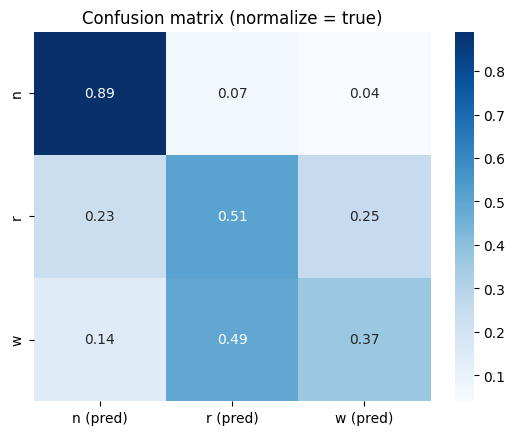

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred, axis=1)
test = np.argmax(y_test, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')


print(classification_report(test, pred, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()